# Supervised Model 

## Table of Contents
1. [Model Choice](#model-choice)
2. [Implementation](#implementation)
3. [Evaluation](#evaluation)


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate

In [2]:
# Check TF versions and CPU/GPU availability
print(tf.__version__)
print(tf.config.list_physical_devices())
print(tf.test.is_gpu_available)
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.19.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_gpu_available at 0x7aa63f124e00>
True
True
Num CPUs Available:  1
Num GPUs Available:  1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pwd
!ls

/content
drive  sample_data


In [5]:
import os
os.chdir("/content/drive/My Drive/Untrained-PINN-for-SIM-main")
print(os.getcwd())

/content/drive/My Drive/Untrained-PINN-for-SIM-main


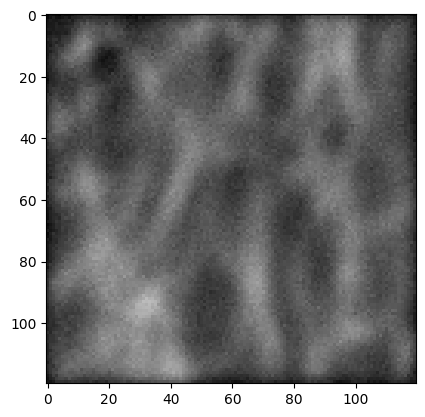

In [6]:
import cv2#show first picture of folder as image in notebook
img = cv2.imread('Data/LPSIM/microtubules/input_frames/1_1.png')
plt.imshow(img)

## Model Choice

Based on the publication notebook PINN_demo_plasmonic_SIM of an untrained PINN, a supervised model was chosen.


## Implementation


In [7]:
import numpy as np
import cv2

num_im = 50      # Number of examples in dataset
frames = 24       # Number of sub-frames per example
im_dim = 480     # Image dimension (after super-res)
bg_lvl = 0       # Optional bg level subtraction

input_frames = np.zeros([num_im,im_dim,im_dim,frames])
gt_frames = np.zeros([num_im,im_dim,im_dim,1])
lr_frames = np.zeros([num_im,im_dim,im_dim,1])
patterns = np.zeros([frames,im_dim,im_dim,1])


## Load Data

In [8]:
#Load data
data_name = 'microtubules'
dir_name = 'Data/LPSIM/'

for i in range(1,num_im):

    for j in range(1,(frames+1)):

        input_path = dir_name+data_name+'/input_frames/'+str(i)+'_'+str(j)+'.png'
        input_temp = cv2.imread(input_path,0)
        input_temp = cv2.resize(input_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
        input_frames[i-1,:,:,j-1] = input_temp

    gt_path = dir_name+data_name+'/ground_truth/'+str(i)+'.png'
    gt_temp = cv2.imread(gt_path,0)
    gt_temp = cv2.resize(gt_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
    gt_temp = gt_temp.reshape([im_dim,im_dim,1])
    gt_frames[i-1,:,:,:] = gt_temp

    lr_path = dir_name+data_name+'/low_res/'+str(i)+'.png'
    lr_temp = cv2.imread(lr_path,0)
    lr_temp = cv2.resize(lr_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
    lr_temp = lr_temp.reshape([im_dim,im_dim,1])
    lr_frames[i-1,:,:,:] = lr_temp


for i in range(1,(frames+1)):

    pattern_path = dir_name+data_name+'/patterns/'+str(i)+'.png'
    pattern_temp = cv2.imread(pattern_path,0)
    pattern = cv2.resize(pattern_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
    pattern = pattern.reshape([im_dim,im_dim,1])
    patterns[i-1,:,:,:] = pattern

# Normalize data
input_frames = input_frames - bg_lvl;
input_frames[input_frames<0] = 0
input_frames = input_frames/np.amax(input_frames)
gt_frames = gt_frames/np.amax(gt_frames) # Corrected typo gt_fames to gt_frames
lr_frames = lr_frames/np.amax(lr_frames)
patterns = patterns/np.amax(patterns)


ind = 2 # Reusing the index from PINN training

x_supervised = lr_frames[ind-1, :, :, :]
x_supervised = x_supervised.reshape([1, im_dim, im_dim, 1])

y_supervised = gt_frames[ind-1, :, :, :]
y_supervised = y_supervised.reshape([1, im_dim, im_dim, 1])

print(f"Shape of x_supervised (input for supervised training): {x_supervised.shape}")
print(f"Shape of y_supervised (target for supervised training): {y_supervised.shape}")

Shape of x_supervised (input for supervised training): (1, 480, 480, 1)
Shape of y_supervised (target for supervised training): (1, 480, 480, 1)


## Define Model

In [9]:
# Define the supervised U-Net model

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate

k_size = 3

def u_net():

    inputs = Input((im_dim,im_dim,1)) # Input for supervised learning is a single LR frame
    block1 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(inputs)
    block2 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(block1)
    block2 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(block2)
    down1 = MaxPooling2D(pool_size=(2,2))(block2)
    block3 = Conv2D(64, (k_size, k_size), padding="same", activation = 'relu')(down1)
    block3 = Conv2D(64, (k_size, k_size), padding="same", activation = 'relu')(block3)
    down2 = MaxPooling2D(pool_size=(2,2))(block3)
    block4 = Conv2D(128, (k_size, k_size), padding="same", activation = 'relu')(down2)
    block4 = Conv2D(128, (k_size, k_size), padding="same", activation = 'relu')(block4)
    down3 = MaxPooling2D(pool_size=(2,2))(block4)
    block5 = Conv2D(256, (k_size, k_size), padding="same", activation = 'relu')(down3)
    block5 = Conv2D(256, (k_size, k_size), padding="same", activation = 'relu')(block5)
    up1 = UpSampling2D(size=(2,2))(block5)
    cat1 = concatenate([block4,up1])
    block6 = Conv2D(128, (k_size, k_size), padding="same", activation = 'relu')(cat1)
    block6 = Conv2D(128, (k_size, k_size), padding="same", activation = 'relu')(block6)
    up2 = UpSampling2D(size=(2,2))(block6)
    cat2 = concatenate([block3,up2])
    block7 = Conv2D(64, (k_size, k_size), padding="same", activation = 'relu')(cat2)
    block7 = Conv2D(64, (k_size, k_size), padding="same", activation = 'relu')(block7)
    up3 = UpSampling2D(size=(2,2))(block7)
    cat3 = concatenate([block2,up3])
    block8 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(cat3)
    block8 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(block8)
    block9 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(block8)
    output = Conv2D(1, (1, 1), padding="same")(block9)
    output = tf.keras.layers.ReLU(max_value=1.0)(output)

    model = tf.keras.Model(inputs=[inputs], outputs=[output])

    return model

supervised_model = u_net()
print("Supervised U-Net model instantiated.")

Supervised U-Net model instantiated.


In [10]:
#Defining Loss function 
mse_loss = tf.keras.losses.MeanSquaredError()
print("Mean Squared Error loss function defined.")

Mean Squared Error loss function defined.


**Mean Squared Error (MSE)** 


The formula for MSE is:

$$MSE = \frac{1}{N} \sum_{i=1}^{N} (Y_i - \hat{Y}_i)^2$$

Where:

*   $N$ is the total number of pixels in the image.
*   $Y_i$ is the actual pixel value in the ground truth image.
*   $\hat{Y}_i$ is the predicted pixel value from the model.


In [11]:
#Compile the model

learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate,
    decay_steps=50,
    decay_rate=0.90,
    staircase=True)

opt_supervised = tf.keras.optimizers.Adam(lr_schedule)
batch_size = 1
eps = 1000

supervised_model.compile(loss=mse_loss, optimizer=opt_supervised)
supervised_model_history = supervised_model.fit(x=x_supervised, y=y_supervised, epochs=eps, batch_size=batch_size)

print("Supervised model compiled and trained.")
print(f"Final training loss (MSE): {supervised_model_history.history['loss'][-1]}")

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - loss: 0.0197
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0176
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0157
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0136
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0115
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0095
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0077
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0064
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0062
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0070
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0075
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0073
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0068
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0063
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss

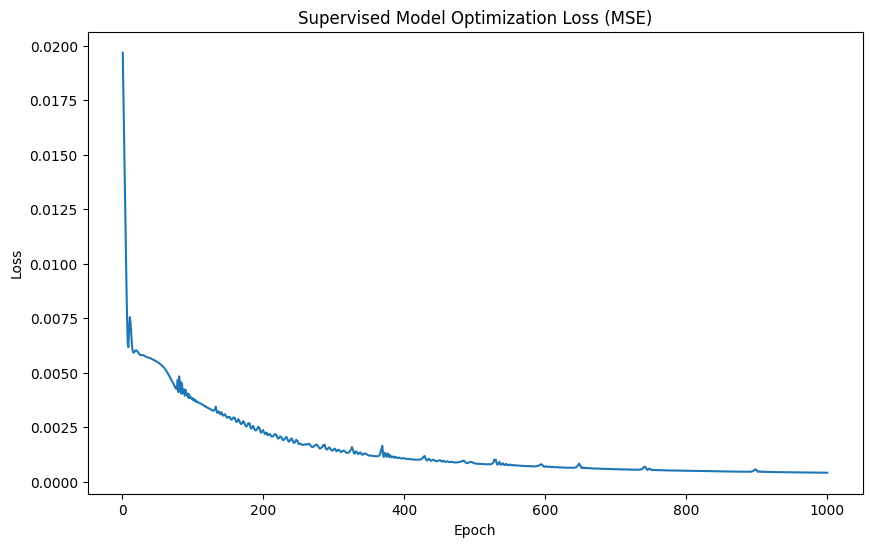

In [12]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(1, eps, num=eps), supervised_model_history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Supervised Model Optimization Loss (MSE)')
plt.show()

## Evaluation

A visual comparison of the original and ground truth images with the predicted image of the supervised model



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


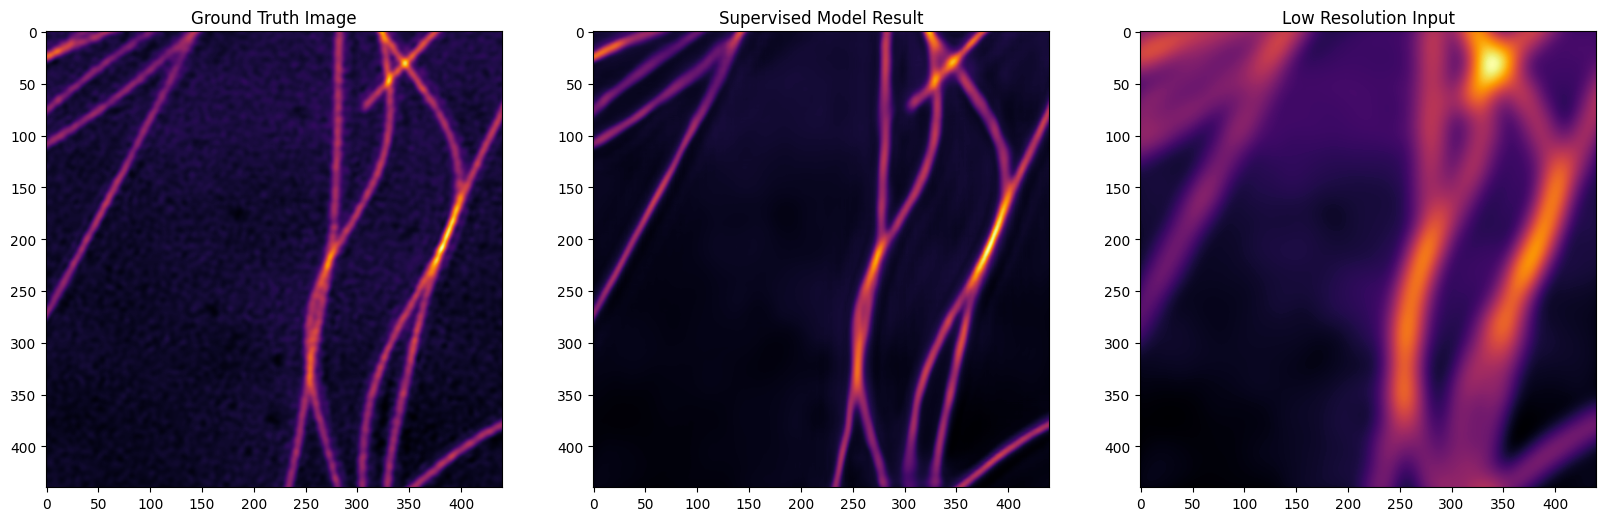

In [13]:
#compare results

predicted_supervised = supervised_model.predict(x_supervised)

# Reshape and normalize the predicted image
predicted_supervised = predicted_supervised.reshape([im_dim, im_dim])
predicted_supervised = predicted_supervised[20:(im_dim-20), 20:(im_dim-20)]
predicted_supervised = (predicted_supervised - np.amin(predicted_supervised)) / (np.amax(predicted_supervised) - np.amin(predicted_supervised))

# Prepare ground truth (y_supervised) for visualization
gt_supervised_viz = y_supervised.reshape([im_dim, im_dim])
gt_supervised_viz = gt_supervised_viz[20:(im_dim-20), 20:(im_dim-20)]
gt_supervised_viz = (gt_supervised_viz - np.amin(gt_supervised_viz)) / (np.amax(gt_supervised_viz) - np.amin(gt_supervised_viz))

# Prepare low-resolution input (x_supervised) for visualization
lr_supervised_viz = x_supervised.reshape([im_dim, im_dim])
lr_supervised_viz = lr_supervised_viz[20:(im_dim-20), 20:(im_dim-20)]
lr_supervised_viz = (lr_supervised_viz - np.amin(lr_supervised_viz)) / (np.amax(lr_supervised_viz) - np.amin(lr_supervised_viz))

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(gt_supervised_viz, cmap='inferno')
plt.title('Ground Truth Image')
plt.subplot(1,3,2)
plt.imshow(predicted_supervised, cmap='inferno')
plt.title('Supervised Model Result')
plt.subplot(1,3,3)
plt.imshow(lr_supervised_viz, cmap='inferno')
plt.title('Low Resolution Input')
plt.show()